2602088986_Calvin Alexander

2602094206_Dean Hans Felandio Setiadi Saputra

2602091040_Marvella Shera Devi

2602093600_Verren Angelina Saputra

In [1]:
import torch
import torch.nn as nn   
import torchvision as vision
import torch.nn.functional as F

In [2]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Lovely [Resnet](https://arxiv.org/abs/1512.03385)

ResNet is special because it introduced residual connections, which allow the network to "skip" layers, making it easier to train very deep networks by avoiding the vanishing gradient problem. 

This architecture enables networks to be much deeper while improving performance, revolutionizing deep learning for tasks like image recognition.

Skip layers (residual connections) work mathematically because they preserve the gradient flow during backpropagation, allowing the model to avoid the vanishing gradient problem. By adding the input 𝑥 directly to the output of a block 

output of a block = F(𝑥)+𝑥

The addition operation ensures that the gradient flows through the network more easily. The skip connection contributes a gradient of 1, allowing the gradient to pass directly through without being diminished, which helps prevent vanishing gradients and makes training deep networks more effective.





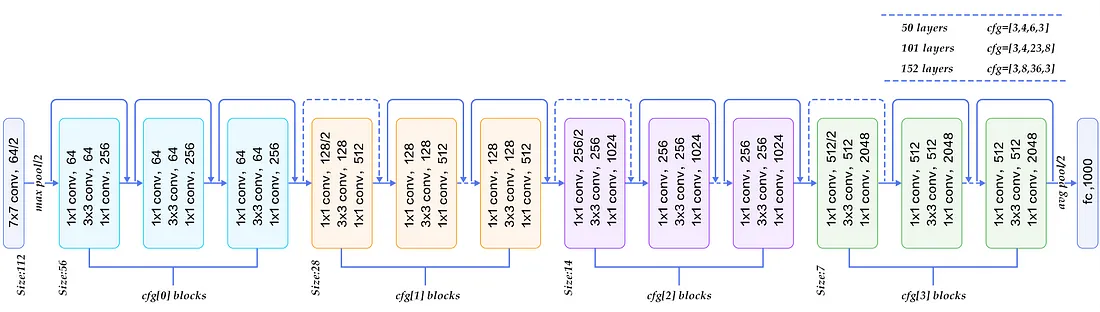

Block of Resnet

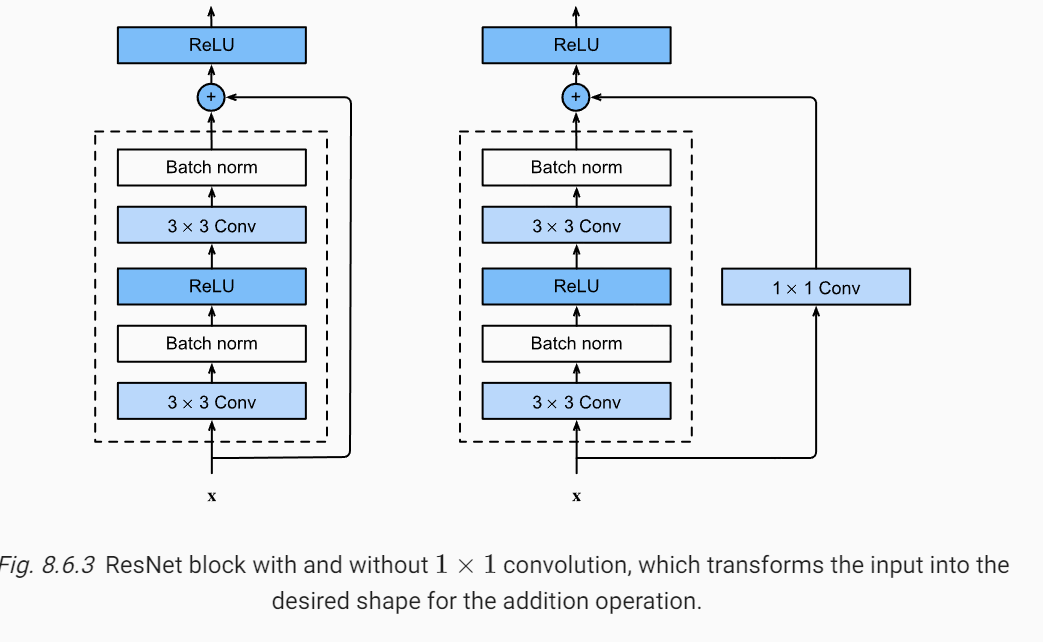
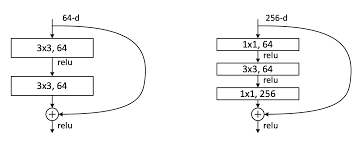

In [3]:
#Block Block of ResNet
class Block(nn.Module):
    def __init__(self, in_channels,out_channels, stride=1, identity_downsample=None):
        '''
        A block composed by two 3x3 convolutional layers with batch normalization and ReLU activation. Also, with residual conenction
        
        in_planes: The number of input channels to the convolutional layer.
        planes: The number of output channels (or feature maps) for the convolutional layers.
        stride: The stride of the first convolutional layer. Default is 1.
        is_last: A boolean flag to indicate if this is the last layer in the block. Default is False.
        '''
        super(Block, self).__init__()
        # self.is_last = is_last #To check if it is the last layer or not because the last layer will have different structure
        
        self.expansion=4 #Number of channels is 4 times larger than the input (ResNet50)
        
        #1x1 Convolution Layer
        self.conv1= nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1=nn.BatchNorm2d(out_channels)
        
        # 3x3 Convolution Layer
        self.conv2= nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1) 
        self.bn2=nn.BatchNorm2d(out_channels)
        
        #1x1 Convolution Layer        
        self.conv3=nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3=nn.BatchNorm2d(out_channels*self.expansion)
        
        self.relu=nn.ReLU()
        
        #Identity downsample is used to match the dimensions of the input and output of the residual block (Will be passed as a parameter)
        self.identity_downsample=identity_downsample
        
    def forward(self, x):
        identity=x #For residual connection
        
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        
        x=self.conv2(x)
        x=self.bn2(x)
        x=self.relu(x)
        
        x=self.conv3(x)
        x=self.bn3(x)
        
        # print('===')
        # print(identity.shape)
        #if the input and output dimensions are different, then we need to perform identity downsample
        if self.identity_downsample is not None:
            identity=self.identity_downsample(identity)
        
        # print('=========')
        # print(identity.shape), print(x.shape)
        x+=identity #Residual connection
        x=self.relu(x)
        return x
    
    def get_expansion(self):
        return self.expansion

Resnet Architechture

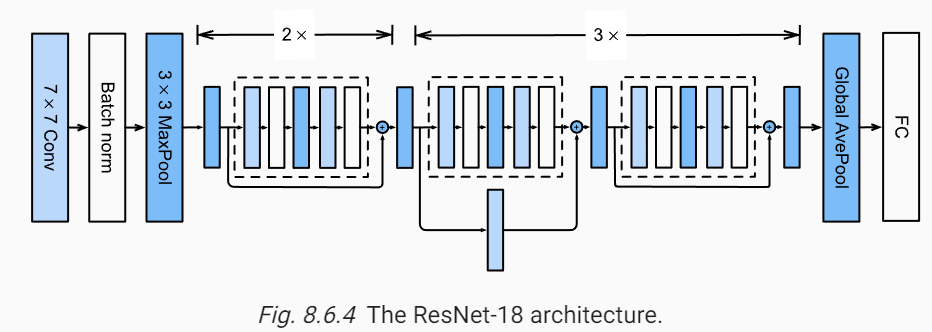
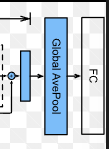
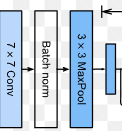

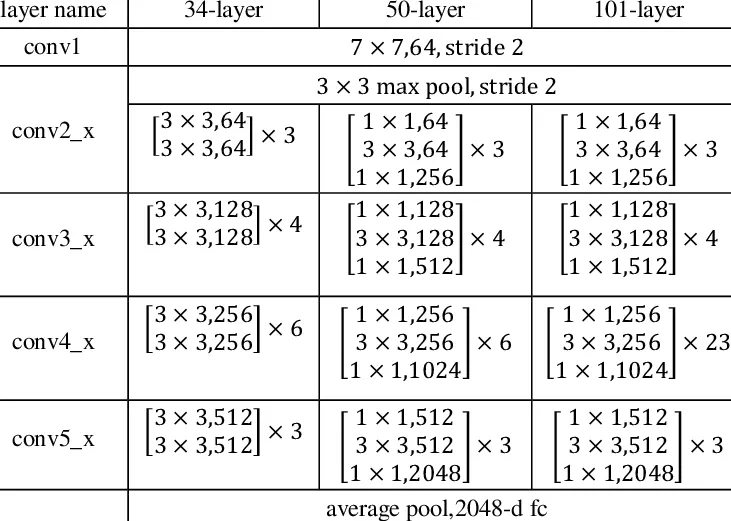

In [4]:
class ResNet(nn.Module):
    '''
        ResNet Architecture, composed by a series of blocks. Each block is composed by a series of Block blocks.
    '''
    
    
    def __init__(self,block, layers, image_channels, num_classes):
        super(ResNet, self).__init__() 
        
        self.expand=4 
        
        #Opening Layers (Left Side of Image)
        self.in_channels=64 #Initial number of channels
        self.conv1=nn.Conv2d(image_channels, self.in_channels, kernel_size=7, stride=2, padding=3) #Convolution Layer
        self.bn1=nn.BatchNorm2d(64)
        self.relu=nn.ReLU()
        self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #Residual Layers
        self.layer1=self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2=self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3=self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4=self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        #Closing Layers (Right Side of Image)
        self.avgpool=nn.AdaptiveAvgPool2d((1,1)) #Define the output size and automatically adjust the kernel size
        self.fc=nn.Linear(512*self.expand, num_classes) #Fully connected layer (52*4 because the output of the last layer is 512*4)

    #Forward pass
    def forward(self, x):
        x=self.conv1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.maxpool(x)
        
        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=x.reshape(x.shape[0], -1) #Flatten the output of the last layer
        
        x=self.fc(x)
        
        return x
        
    #Function to create the residual layers
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample=None
        layers=[] #List of layers
        
        #If the input and output dimensions are different, then we need to perform identity downsample
        
                
        
        if stride != 1 or self.in_channels != out_channels * self.expand:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * self.expand, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels * self.expand)
            )

        layers.append(block(self.in_channels,out_channels, stride, identity_downsample=identity_downsample)) #Add the first layer to the list
        self.in_channels=out_channels*self.expand #Update the number of input channels for the next layer
        
        '''
        Bottleneck journey
        Input: 256 channels
            ↓
        [1x1 conv]  256 → 64 (uses out_channels)
            ↓
        [3x3 conv]  64 → 64 (uses out_channels)
            ↓
        [1x1 conv]  64 → 256 (out_channels * 4)
        Output: 256 channels

        '''
        
        for i in range(num_residual_blocks-1):
            layers.append(block(self.in_channels, out_channels)) #256x64, 64 is the number of output channels
            
        return nn.Sequential(*layers)

In [5]:
def ResNet50(num_classes, img_channels=3):
    '''
    ResNet50 Architecture Default
    3x3 Convolutional Layer with 64 filters, 
    followed by 4 residual blocks with 3,4,6,3 Block blocks each.
    1 Fully connected layer with 1000 output classes.
    50 stands for the number of layers in the network.
    '''
    return ResNet(Block, [3,4,6,3], img_channels, num_classes)

In [6]:
def ResNet101(num_classes, img_channels=3):
    '''
    ResNet101 Architecture Default
    3x3 Convolutional Layer with 64 filters, 
    followed by 4 residual blocks with 3,4,23,3 Block blocks each.
    1 Fully connected layer with 1000 output classes.
    
    '''
    return ResNet(Block, [3,4,23,3], img_channels, num_classes)

In [7]:
#Smaller ResNet 
def CustRestNet(num_classes, img_channels=3, block=Block, architecture=[1,1,1,1]):
    '''
    Resnet Training with custom architecture
    '''
    return ResNet(block,architecture , img_channels, num_classes)

### CIFAR10

CIFAR-10 is a dataset for image classification, consisting of 60,000 32x32 color images in 10 different classes (e.g., airplanes, cars, animals), with 6,000 images per class. The dataset is split into 50,000 training images and 10,000 test images, and is commonly used to benchmark and evaluate the performance of deep learning algorithms in computer vision.

In [8]:
import os, torchvision
from torchvision import transforms

In [9]:
#Random state seed for reproducibility
torch.manual_seed(42)

Replicating Resnet Paper augmentation on CIFAR10

4 pixels are padded on each side, and a 32×32 crop is randomly sampled from the padded image or its horizontal flip. For testing, we only evaluate the single view of the original 32×32 image.

In [10]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Pad 4 pixels on each side and then randomly crop to 32x32
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.ToTensor(), # Convert the image to a tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalize with CIFAR-10 mean and std
    transforms.RandomErasing() # Randomly erase a rectangle from the image
])

# Normalization for validation/testing
test_transforms = transforms.Compose([
    transforms.ToTensor(), # Convert the image to a tensor and scale pixel values to [0, 1]
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])  # Normalize with CIFAR-10 mean and std
])

In [11]:
train_data= torchvision.datasets.CIFAR10(root='./CIFAR10', train=True, transform=train_transforms, download=True)
test_data= torchvision.datasets.CIFAR10(root='./CIFAR10', train=False, transform=test_transforms, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
train_loader=torch.utils.data.DataLoader(dataset=train_data, batch_size=128, shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_data,  shuffle=True)

In [15]:
for x,y in train_loader:
    print(x.shape)
    break
for x,y in test_loader:
    print(x.shape)
    break

torch.Size([128, 3, 32, 32])
torch.Size([1, 3, 32, 32])


shape -> (batch size, 3 channels, 32, 32)

In [16]:
len(train_loader), len(test_loader)

(391, 10000)

### Training

In [17]:
# Define the custom ResNet model
arch = [1, 2, 3, 1]  # Custom architecture with 1,2,3,1 blocks
model = CustRestNet(num_classes=10, img_channels=3, architecture=arch).to(device)
# model = ResNet50(num_classes=10, img_channels=3).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
patience = 8
best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

In [18]:
model.load_state_dict(torch.load('lastest-augmented-small.pth'))
#Kalo mau lanjutin training load ini dulu baru run training loop

<All keys matched successfully>

In [17]:

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    if early_stop:
        print("Early stopping triggered after {} epochs.".format(epoch))
        break

    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if (i + 1) % 782 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 782:.4f}')
            running_loss = 0.0
    
    
    
    # Check accuracy on test data after every 10 epochs
    if (epoch +1)%10==0:
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            correct, total = 0, 0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
            val_loss /= len(test_loader)
            print(f'Validation Loss: {val_loss:.4f}')
            print(f'Accuracy on test data: {100 * correct / total}%')
    
    
        # Early stopping
        if val_loss < best_loss: # Save the model with the best validation loss
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model-augmented.pth')
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            early_stop = True

torch.save(model.state_dict(), 'best_model-augmented.pth')
print('Finished Training')

Epoch [1/100], Step [782/782], Loss: 0.3655
Epoch [2/100], Step [782/782], Loss: 0.3584
Epoch [3/100], Step [782/782], Loss: 0.3338
Epoch [4/100], Step [782/782], Loss: 0.3979
Epoch [5/100], Step [782/782], Loss: 0.3282
Epoch [6/100], Step [782/782], Loss: 0.3175
Epoch [7/100], Step [782/782], Loss: 0.3090
Epoch [8/100], Step [782/782], Loss: 0.2978
Epoch [9/100], Step [782/782], Loss: 0.2883
Epoch [10/100], Step [782/782], Loss: 0.3004
Validation Loss: 0.5143
Accuracy on test data: 84.2%
Epoch [11/100], Step [782/782], Loss: 0.2849
Epoch [12/100], Step [782/782], Loss: 0.2629
Epoch [13/100], Step [782/782], Loss: 0.2597
Epoch [14/100], Step [782/782], Loss: 0.2558
Epoch [15/100], Step [782/782], Loss: 0.2576
Epoch [16/100], Step [782/782], Loss: 0.2477
Epoch [17/100], Step [782/782], Loss: 0.2453
Epoch [18/100], Step [782/782], Loss: 0.3434
Epoch [19/100], Step [782/782], Loss: 0.2763
Epoch [20/100], Step [782/782], Loss: 0.2577
Validation Loss: 0.5230
Accuracy on test data: 84.75%
Ep

KeyboardInterrupt: 

```
Validation Loss: 0.6100
Accuracy on test data: 87.92%
```

In [ ]:
model.load_state_dict(torch.load('best_model-augmented.pth'))

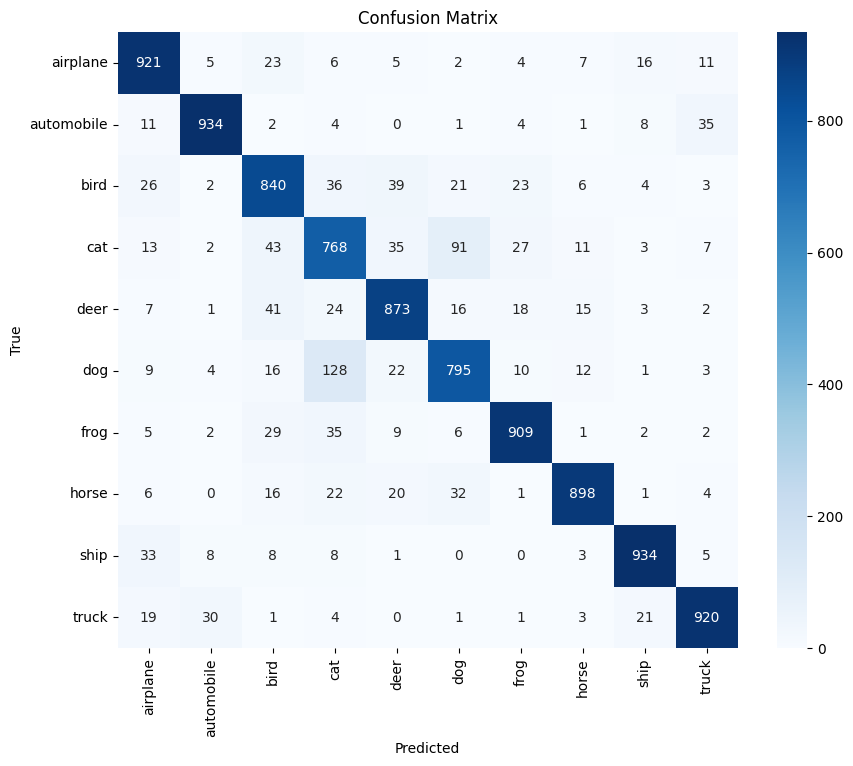

Classification Report
              precision    recall  f1-score   support

    airplane       0.88      0.92      0.90      1000
  automobile       0.95      0.93      0.94      1000
        bird       0.82      0.84      0.83      1000
         cat       0.74      0.77      0.75      1000
        deer       0.87      0.87      0.87      1000
         dog       0.82      0.80      0.81      1000
        frog       0.91      0.91      0.91      1000
       horse       0.94      0.90      0.92      1000
        ship       0.94      0.93      0.94      1000
       truck       0.93      0.92      0.92      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import matplotlib.pyplot as plt

# model.load_state_dict(torch.load('best_model-augmented.pth'))

# Function to plot images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get all predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(all_labels, all_preds, target_names=train_data.classes))

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


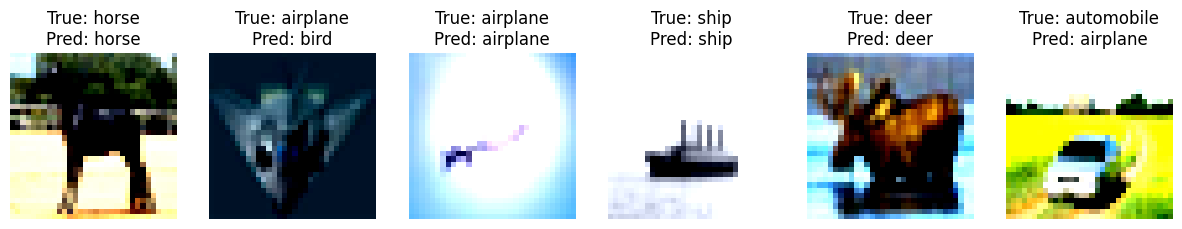

In [20]:
import random

# Function to plot images with predictions
def plot_random_predictions(num_images=6):
    indices = random.sample(range(len(test_data)), num_images)
    images, labels, preds = [], [], []
    
    for idx in indices:
        img, label = test_data[idx]
        images.append(img)
        labels.append(label)
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img)
            _, pred = torch.max(output, 1)
            preds.append(pred.item())
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        ax = axes[i]
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)))
        ax.set_title(f'True: {train_data.classes[labels[i]]}\nPred: {train_data.classes[preds[i]]}')
        ax.axis('off')
    plt.show()

plot_random_predictions()

In [21]:
#Model.summary from the model
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr